In [1]:
import sys
import os
from glob import glob

import numpy as np
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import geopandas as gpd

import json 
import plotly.express as px

import altair as alt

import matplotlib.pyplot as plt
from matplotlib import rcParams
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

import sqlalchemy as db
from sqlalchemy.orm import sessionmaker
import geoalchemy2

from datetime import datetime, date, timedelta
from dateutil.relativedelta import *
from dateutil.parser import parse

from IPython.display import display, HTML, Image
import ipywidgets as wgts

import ee
import geemap
# import cartoee as cee
# import eeconvert as eec

import pprint as pp
import warnings

import folium

In [2]:
ee.Initialize()

In [3]:
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 24,12

In [169]:
df = pd.read_csv('scouting/mozambia.csv')

In [170]:
df.drop(columns='geometry', inplace=True)

In [171]:
df.fillna(0, inplace=True)

In [172]:
df.isna().sum()

Unnamed: 0                 0
country                    0
lat                        0
lon                        0
id                         0
sub_region                 0
region                     0
village                    0
district                   0
number_scouting            0
scouting_plants_checked    0
scouting_plants_faw        0
hecatres_checked           0
date                       0
perc_numeric               0
presence                   0
dtype: int64

In [173]:
df.country.unique()

array(['Mozambique', 'Zambia'], dtype=object)

In [174]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

In [175]:
gdf

,Unnamed: 0,country,lat,lon,id,sub_region,region,village,district,number_scouting,scouting_plants_checked,scouting_plants_faw,hecatres_checked,date,perc_numeric,presence,geometry
0,424,Mozambique,-19.299744,33.248986,62861,Sub-Saharan Africa,Africa,nhambaba 3,Manica,1,50,27.0,3.00,2022-04-06,0.54,1,POINT (33.24899 -19.29974)
1,425,Mozambique,-15.637863,34.396655,57779,Sub-Saharan Africa,Africa,Missama Moatize,Tete,1,50,4.0,2.00,2022-04-02,0.08,0,POINT (34.39666 -15.63786)
2,426,Mozambique,-22.194675,35.052885,70433,Sub-Saharan Africa,Africa,Mulungo,Inhambane Province,1,50,34.0,1.00,2022-05-11,0.68,1,POINT (35.05289 -22.19468)
3,427,Mozambique,-16.097872,35.767470,70459,Sub-Saharan Africa,Africa,Paquete,Zambezia Province,1,50,25.0,0.25,2022-05-13,0.50,1,POINT (35.76747 -16.09787)
4,428,Mozambique,-14.940438,37.522430,59775,Sub-Saharan Africa,Africa,canhunha,Nampula,1,50,16.0,2.00,2022-04-05,0.32,1,POINT (37.52243 -14.94044)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1256,Zambia,-15.529634,28.490958,71863,Sub-Saharan Africa,Africa,"Chongwe, Kanakantampa, J",Lusaka Province,1,50,46.0,0.11,2022-06-16,0.92,1,POINT (28.49096 -15.52963)
663,1257,Zambia,-16.808090,26.987046,71097,Sub-Saharan Africa,Africa,"choma,central A,kabanana",Southern Province,1,50,12.0,1.00,2022-06-22,0.24,1,POINT (26.98705 -16.80809)
664,1258,Zambia,-10.251993,33.368077,71063,Sub-Saharan Africa,Africa,Mafinga,Muchinga Province,1,50,18.0,0.05,2022-06-22,0.36,1,POINT (33.36808 -10.25199)
665,1259,Zambia,-14.440750,28.446371,70767,Sub-Saharan Africa,Africa,"Luano, Mboroma, Chipili","Central Province, Zambia",1,50,35.0,2.00,2022-06-09,0.70,1,POINT (28.44637 -14.44075)


In [176]:
df_grp_by_date = gdf.groupby([df['date']])

In [11]:
available_dates = [key for key in df_grp_by_date.groups.keys()]

dropdown_group_date = wgts.Dropdown(
    description='Group Date',
    options=available_dates,
    value= available_dates[0]        
)
dropdown_group_date

Dropdown(description='Group Date', options=('2022-04-01', '2022-04-02', '2022-04-04', '2022-04-05', '2022-04-0…

In [12]:
def data_by_date(value):
    if value is None:
        value = dropdown_group_date[0]
    
    global daily_group
    daily_group = df_grp_by_date[['id','date','country','geometry']].get_group(value)
    
    return daily_group

In [13]:
engine = db.create_engine('postgresql+psycopg2://postgres@localhost:5432/ml_faw')
con = engine.connect()
metadata = db.MetaData()

In [14]:
# Defining A connection string and making a connection
########################################################################
%load_ext sql
connection_string = f"postgresql+psycopg2://postgres@localhost:5432/ml_faw"
%sql $connection_string
########################################################################

In [15]:
results = %sql select * from temperatures limit 10;
results

 * postgresql+psycopg2://postgres@localhost:5432/ml_faw
10 rows affected.


id,tmin,tmax,mean_temperature
57564,19.1946,29.2414,24.218
72077,20.3182,32.0538,26.186
57665,18.1703,31.5879,24.8791
57643,20.8169,30.6682,25.7425
57668,18.1703,31.5879,24.8791
57667,18.1703,31.5879,24.8791
57681,20.3182,32.0538,26.186
57669,18.1703,31.5879,24.8791
72078,20.3182,32.0538,26.186
57553,21.7172,30.656,26.1866


In [16]:
# results_df = results.DataFrame()
# results_df.head()

In [17]:
# results.dict()
# results.field_names
# results.index

In [18]:
# mean_t = 28

In [19]:
# %%sql 
# result << SELECT id,mean_temperature 
#           FROM temperatures
#           WHERE mean_temperature >= :mean_t

In [20]:
# result

In [21]:
countries = gpd.read_file("data/custom.geo.json")

<AxesSubplot:>

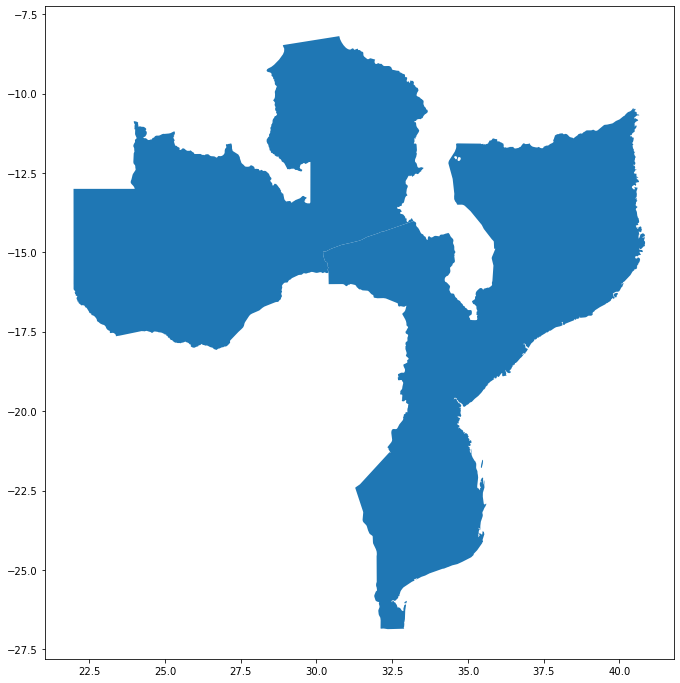

In [22]:
aoi = countries.loc[countries['sovereignt'].isin(['Mozambique','Zambia'])]
aoi.plot()

# Google Earth Engine Settings

## Charting

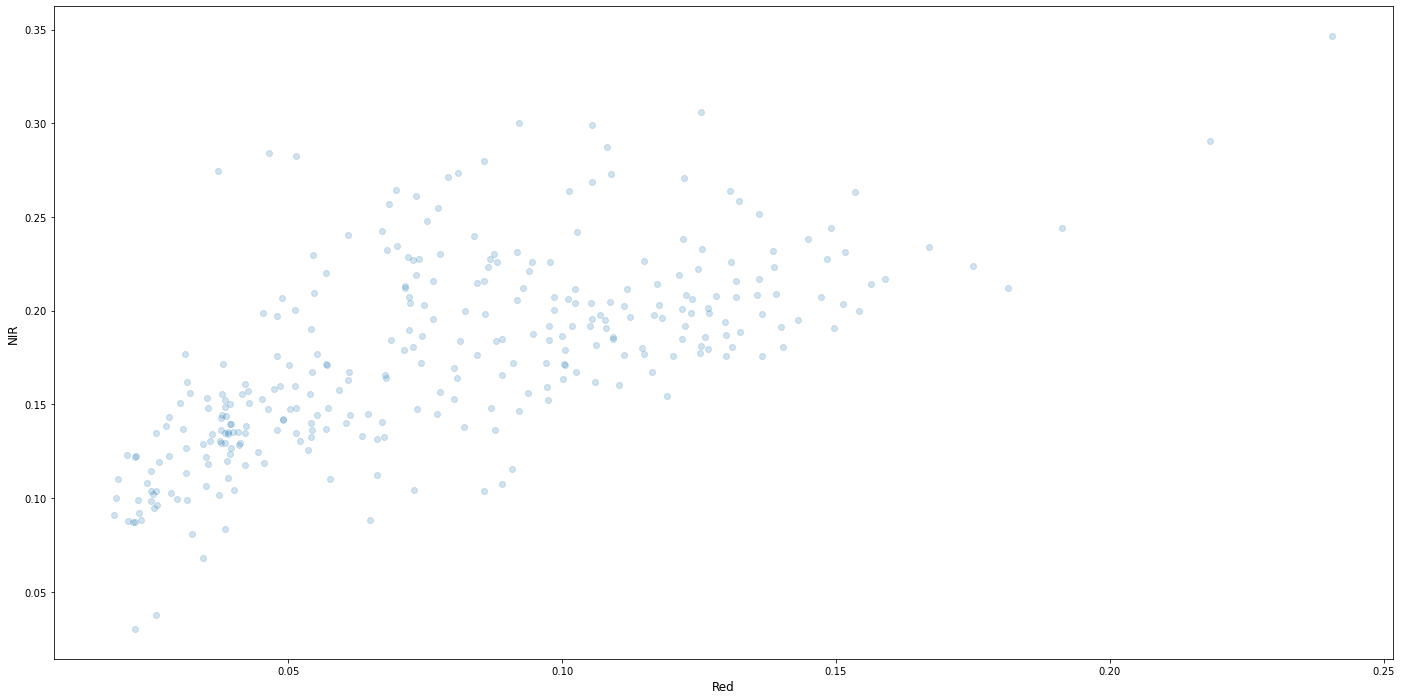

In [22]:
# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

## Common Params

In [23]:
start_date='2022-03-15'
ee_start_date=ee.Date(start_date)

end_date='2022-07-20'
ee_end_date=ee.Date(end_date)

In [24]:
aoi= eec.gdfToFc(countries)

## Common Function

In [25]:
Map = geemap.Map(center=[6,41], zoom=6)

In [26]:
# Function to Convert Feature Classes to Pandas Dataframe
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        dictarr.append(attr)

    return pd.DataFrame(dictarr)

In [28]:
def ClippingOnAOIArea(image):    
    return image.clip(aoi)

In [30]:
def add_data(data_pass,viz={},name='NULL NAME'):    
    Map.addLayer(data_pass,{},name)

In [31]:
def convert_eedate_2_date(ee_date):
    return datetime.utcfromtimestamp(ee_date.getInfo()['value']/1000.0)

In [32]:
def convert_date_2_eeDate(py_date):
    return ee.Date(py_date)

In [33]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
  ).add_to(self)

# Google Earth Engine Data Collection

## GLDAS 3Hourly

| Name | 	Units |	Min |	Max |	Description|
| --- | --- | --- | --- | --- |
|ECanop_tavg |	W/m^2 |	0* |	1273.66* |	Canopy water evaporation
|ESoil_tavg |	W/m^2 |	0* |	2275.63* |	Direct evaporation from bare soil
|Evap_tavg |	kg/m^2/s |	0* |	0.002* |	Evapotranspiration
|PotEvap_tavg | 	W/m^2 |	-227.75* |	18977.9* |	Potential evaporation rate
|Qair_f_inst |	kg/kg |	-0.02* |	0.07* |	Specific humidity |
|Rainf_f_tavg |	kg/m^2/s |	0* |	0.01* |	Total precipitation rate |
|Rainf_tavg |	kg/m^2/s |	0* |	0.01* |	Rain precipitation rate |
|RootMoist_inst |	kg/m^2 |	2* |	949.6* |	Root zone soil moisture |
|SoilMoi0_10cm_inst |	kg/m^2 |	1.99* |	47.59* |	Soil moisture |
|SoilMoi10_40cm_inst |	kg/m^2 |	5.99* |	142.8* |	Soil moisture
|SoilMoi40_100cm_inst |	kg/m^2 |	11.99* |	285.6* |	Soil moisture |
|SoilMoi100_200cm_inst |	kg/m^2 |	20* |	476* |	Soil moisture |
|SoilTMP0_10cm_inst |	K |	221.98* |	377.5* |	Soil temperature |
|SoilTMP10_40cm_inst |	K |	227.43* |	319.44* |	Soil temperature |
|SoilTMP40_100cm_inst |	K |	232.97* |	316.2* |	Soil temperature |
|SoilTMP100_200cm_inst |	K |	238.52* |	314.11* |	Soil temperature|
|Swnet_tavg |	W/m^2 |	-48.96* |	23741.3* |	Net short wave radiation flux |
|Tair_f_inst |	K |	206.8* |	327.66* |	Air temperature |
|Tveg_tavg |	W/m^2 |	0* |	3455.14* |	Transpiration |
|Wind_f_inst |	m/s |	0* |	57.7* |	Wind speed |

In [34]:
GLDAS_3H = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H")
sm = GLDAS_3H.select('RootMoist_inst').filterDate(start_date, end_date)

### Aggregate by day grouping 3hourly data

In [36]:
collection_3hours_gldas = GLDAS_3H.select('RootMoist_inst').filterDate(ee_start_date,ee_end_date) 
#,'SoilMoi10_40cm_inst','SoilMoi40_100cm_inst','SoilTMP0_10cm_inst','SoilTMP10_40cm_inst','SoilTMP40_100cm_inst'
numberOfDays = ee_end_date.difference(ee_start_date, 'days')

In [37]:
collection_3hours_gldas.size().getInfo()

911

In [38]:
numberOfDays.getInfo()

127

In [39]:
sm_aggregated_daily = ee.ImageCollection(ee.List.sequence(0, numberOfDays.subtract(1)).map(
                                               lambda dayOffset: collection_3hours_gldas.filterDate(ee_start_date.advance(dayOffset, 'days'), 
                                                                                                    ee_start_date.advance(dayOffset, 'days').advance(1,'days'))
                                                                                                    .mean()
                                                                                                    .set({'system:time_start': ee_start_date.advance(dayOffset, 'days').millis()})
                                                                             )
                          )

In [40]:
pp.pprint(sm_aggregated_daily.first().getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'precision': 'float', 'type': 'PixelType'},
            'id': 'RootMoist_inst'}],
 'properties': {'system:index': '0', 'system:time_start': 1647302400000},
 'type': 'Image'}


In [49]:
sm_aggregated_daily.first().select('RootMoist_inst').bandNames().getInfo()

['RootMoist_inst']

In [42]:
band_first_image = sm_aggregated_daily.first().select('RootMoist_inst')
visualization = {'min': 0, 'max': 950, 'dimensions': 512, 'palette': ['D8D8D8', '006633', 'E5FFCC']}

In [55]:
ee.Date(sm_aggregated_daily.first().get('system:time_start')).format('YYYY/M/d').getInfo()

'2022/3/15'

In [43]:
Image(url = band_first_image.getThumbURL(visualization))

In [56]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
my_map = folium.Map(location=[20, 15], zoom_start=4)

# Add the elevation model to the map object.
my_map.add_ee_layer(band_first_image, visualization, 'RootMoist_inst')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### Testing Mean Data

In [57]:
test_start_date = ee.Date('2022-06-10')
test_end_date = ee.Date('2022-06-20')
sm_10days = sm_aggregated_daily.filterDate(test_start_date,test_end_date)
sm_aggregated_10days = sm_10days.mean()
sm_aggregated_10days.getInfo()

{'type': 'Image',
 'bands': [{'id': 'RootMoist_inst',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [58]:
colors = ['#8e471b','#a47c5d','#cfb53b','#9aa655','#50c878','#008844','#0a7e8c']
# colors.reverse()

In [59]:
Image(url = sm_aggregated_10days.getThumbURL(visualization))

In [60]:
sm_10days_vis = {'min': 0,'max': 950, 'palette': colors}

In [61]:
sm_aggregated_10days_root_level = sm_aggregated_10days.select('RootMoist_inst') #index zero
sm_aggregated_10days_root_level.getInfo()

{'type': 'Image',
 'bands': [{'id': 'RootMoist_inst',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [63]:
Map = geemap.Map()
# Map.addLayer(daily, {}, 'Daily Mean Collection')
Map.addLayer(sm_aggregated_daily.first().select(0), sm_10days_vis, 'Daily')
Map.addLayer(sm_aggregated_10days, sm_10days_vis, 'Ten Days')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Calculations

In [106]:
key_date = '2022-04-01'

In [128]:
daily_group = df_grp_by_date.get_group(key_date)[['id','country','village','district','perc_numeric','date','presence']]
daily_group

,id,country,village,district,perc_numeric,date,presence
323,71485,Zambia,"kitwe,mwekela,chankalamu",Copperbelt Province,0.56,2022-06-30,1
332,71451,Zambia,"Kitwe, Nkana, Parklands",Copperbelt Province,0.70,2022-06-30,1
340,71470,Zambia,"Mongu, Mandanga,ikoselwa","Western Province, Zambia",0.94,2022-06-30,1
341,71735,Zambia,"Kitwe, Nkana, Parklands",Copperbelt Province,0.50,2022-06-30,1
355,71483,Zambia,"kitwe, mwekera,chankalamo",Copperbelt Province,0.94,2022-06-30,1
368,71466,Zambia,"mongu, mucho, icoselo","Western Province, Zambia",1.00,2022-06-30,1
369,71454,Zambia,"kitwe,Nkana, Parkland",Copperbelt Province,0.70,2022-06-30,1
381,71491,Zambia,"Mongu, Boma South, Blue gum","Western Province, Zambia",0.56,2022-06-30,1
382,71497,Zambia,"Kitwe, Nkana, Parklands",Copperbelt Province,0.50,2022-06-30,1
385,71458,Zambia,ikeselo,"Western Province, Zambia",0.94,2022-06-30,1


In [108]:
points_gee = eec.gdfToFc(daily_group)
# points_gee.getInfo()

In [109]:
d = datetime.strptime(key_date, '%Y-%m-%d')
d_10 = d-timedelta(days=10)
print(d,d_10)

2022-04-01 00:00:00 2022-03-22 00:00:00


In [110]:
test_start_date = ee.Date(d_10)
test_end_date = ee.Date(d)
sm_10days = sm_aggregated_daily.filterDate(test_start_date,test_end_date)
# sm_10days.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'features': [{'type': 'Image',
   'bands': [{'id': 'RootMoist_inst',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'system:time_start': 1647907200000, 'system:index': '7'}},
  {'type': 'Image',
   'bands': [{'id': 'RootMoist_inst',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'system:time_start': 1647993600000, 'system:index': '8'}},
  {'type': 'Image',
   'bands': [{'id': 'RootMoist_inst',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',
     'crs_transform': [1, 0, 0, 0, 1, 0]}],
   'properties': {'system:time_start': 1648080000000, 'system:index': '9'}},
  {'type': 'Image',
   'bands': [{'id': 'RootMoist_inst',
     'data_type': {'type': 'PixelType', 'precision': 'float'},
     'crs': 'EPSG:4326',

In [153]:
# Get Values from GEE
def add_values_point_data(img, ini):
    
    # type cast
    initial_features = ee.FeatureCollection(ini)

    # gets the values for the points in the current img
    points_enriched = img.reduceRegions(collection=points_gee, reducer= ee.Reducer.first(), scale=10)  # .get("precipitation")

    # gets the date of the img
    date = img.date().format('YYYY-MM-d')

    # writes the date in each feature
    points_with_date_addedd = points_enriched.map(lambda f: f.set("date", date))

    # merges the FeatureCollections
    return initial_features.merge(points_with_date_addedd)

# Empty Collection to fill
ft = ee.FeatureCollection(ee.List([]))

In [112]:
# Iterates over the ImageCollection
ft_with_soil_moisture = ee.FeatureCollection(sm_10days.iterate(add_values_point_data, ft))

In [113]:
df_soil = fc2df(ft_with_soil_moisture)

In [114]:
df_soil

,Unnamed: 0,country,date,district,first,hecatres_checked,id,lat,lon,number_scouting,perc_numeric,presence,region,scouting_plants_checked,scouting_plants_faw,sub_region,village
0,433,Mozambique,2022-03-22,Sofala,213.857376,0.50,57564,-19.220543,33.963544,1,0.00,0,Africa,50,0,Sub-Saharan Africa,Siluvo Jasse
1,446,Mozambique,2022-03-22,Gaza Province,114.120621,0.50,72077,-24.249006,32.852342,1,1.00,1,Africa,50,50,Sub-Saharan Africa,Mpelane
2,485,Mozambique,2022-03-22,Gaza,99.907875,0.17,57665,-22.720097,31.881419,1,0.88,1,Africa,50,44,Sub-Saharan Africa,Mapuvule
3,518,Mozambique,2022-03-22,Maputo,243.238632,0.08,57643,-26.405225,32.647493,1,0.24,1,Africa,50,12,Sub-Saharan Africa,Missevene
4,527,Mozambique,2022-03-22,Gaza,99.907875,0.28,57668,-22.710001,31.844111,1,1.00,1,Africa,50,50,Sub-Saharan Africa,Mapuvule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,650,Mozambique,2022-03-31,Sofala,239.155243,3.00,57547,-19.205275,33.960202,1,0.00,0,Africa,50,0,Sub-Saharan Africa,Siluvo Jasse
146,685,Mozambique,2022-03-31,Maputo,259.512115,0.24,57619,-26.499496,32.575097,1,0.74,1,Africa,50,37,Sub-Saharan Africa,tinonganine
147,701,Mozambique,2022-03-31,Manica,239.704376,0.50,57559,-19.250268,33.923982,1,0.00,0,Africa,50,0,Sub-Saharan Africa,Siluvo Jasse
148,711,Mozambique,2022-03-31,Gaza,105.824997,1.00,57666,-22.841173,31.977058,1,0.88,1,Africa,50,44,Sub-Saharan Africa,Mapuvule


In [115]:
df_soil_10days_mean = df_soil.groupby('id').mean()['first']
df_soil_10days_mean

id
57547    229.327190
57553    238.052115
57559    230.529816
57564    229.327190
57565    238.052115
57619    254.992676
57643    254.992676
57665    102.485654
57666    105.707890
57667    102.485654
57668    102.485654
57669    102.485654
57681    193.920689
72077    126.801028
72078    126.801028
Name: first, dtype: float64

In [103]:
# gdf = geemap.ee_to_geopandas(ft_with_soil_moisture, selectors=['id', 'country'])
# gdf.head()

,geometry,Unnamed: 0,country,date,district,first,hecatres_checked,id,lat,lon,number_scouting,perc_numeric,presence,region,scouting_plants_checked,scouting_plants_faw,sub_region,village
0,POINT (35.05289 -22.19468),426,Mozambique,2022-05-1,Inhambane Province,168.459122,1,70433,-22.194675,35.052885,1,0.68,1,Africa,50,34,Sub-Saharan Africa,Mulungo
1,POINT (35.11364 -22.16592),479,Mozambique,2022-05-1,Inhambane Province,168.459122,1,70525,-22.165918,35.113640,1,0.36,1,Africa,50,18,Sub-Saharan Africa,Machengue
2,POINT (35.15111 -22.06440),578,Mozambique,2022-05-1,Inhambane Province,168.459122,1,70526,-22.064395,35.151113,1,0.30,1,Africa,50,15,Sub-Saharan Africa,Machengue
3,POINT (35.05289 -22.19468),426,Mozambique,2022-05-2,Inhambane Province,168.067871,1,70433,-22.194675,35.052885,1,0.68,1,Africa,50,34,Sub-Saharan Africa,Mulungo
4,POINT (35.11364 -22.16592),479,Mozambique,2022-05-2,Inhambane Province,168.067871,1,70525,-22.165918,35.113640,1,0.36,1,Africa,50,18,Sub-Saharan Africa,Machengue


In [200]:
# drop_cols = [col for col in df_soil.columns if col not in ['id','country','village','district','perc_numeric','date','presence','lat','lon']]
# drop_cols
# sm_df = pd.DataFrame(data=None, columns=df_soil.columns) #, index=df_soil.index)
# sm_df.drop(columns=drop_cols,inplace=True)
# sm_df

In [203]:
def get_sm_for_day(key_date):
    daily_group = df_grp_by_date.get_group(key_date)[['id','country','village','district','perc_numeric','date','presence','lat','lon']] #'geometry',
#     print(key_date)
#     print(daily_group.isna().sum())
#     print(daily_group)
    global points_gee
    points_gee = geemap.pandas_to_ee(daily_group, latitude="lat", longitude="lon")
#     points_gee = eec.gdfToFc(daily_group)
#     points_gee.getInfo()
    d = datetime.strptime(key_date, '%Y-%m-%d')
    d_10 = d-timedelta(days=10)
#     print(d,d_10)
    start_date_10days_window = ee.Date(d_10)
    end_date_10days_window = ee.Date(d)
    sm_10days = sm_aggregated_daily.filterDate(start_date_10days_window,end_date_10days_window)
#     print(sm_10days.getInfo())
#     # Iterates over the ImageCollection
    ft = ee.FeatureCollection(ee.List([]))
    ft_with_soil_moisture = ee.FeatureCollection(sm_10days.iterate(add_values_point_data, ft))
    daily_df_soil_values = fc2df(ft_with_soil_moisture)
    daily_df_soil_values.to_sql('sm', engine, if_exists='append')
#     print(daily_df_soil_values.dtypes)
#     sm_df.append(daily_df_soil_values)
#     return df_soil

In [204]:
# for daily_label,daily_values in df_grp_by_date: 
# #     enrich_daily_group(ds_chirps_daily,daily_label,daily_values,tbl_name='precipitation')
# #     enrich_daily_group(ds_max_min,daily_label,daily_values,tbl_name='temperatures')
#     # enrich_daily_group(ds_soil_moisture_2020,daily_label,daily_values,tbl_name='soil_moisture')
# #     enrich_daily_group(ds_fcover, daily_label, daily_values, tbl_name='fcover')
#     print(daily_label)    

In [205]:
for key_date in df_grp_by_date.groups.keys():
    get_sm_for_day(key_date)

In [ ]:
# df_soil.sort_values(['id','date'])
df_soil.dtypes

In [ ]:
# df_soil.country.unique()

In [ ]:
# alt.Chart(df_soil).mark_bar().encode(
#     x='country:N',
#     y='SoilMoi0_10cm_inst:Q',
# )

In [ ]:
alt.Chart(df_soil).mark_trail(point=True).encode(
    x='date:T',
    y='SoilMoi0_10cm_inst:Q',
    color='country:N',
    size='SoilMoi0_10cm_inst:Q'
).properties(
    width=650,
    height=350
)

In [ ]:
alt.Chart(df_soil).mark_boxplot().encode(
    x='country:N',
    y='average(SoilMoi0_10cm_inst)',    
).properties(
    width=650,
    height=350
)

# PROBA-V C1 Top Of Canopy Daily Synthesis 100m
## var dataset = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M')

|Name |Units |Wavelength |Description|
|----|----|----|----|
|RED |	658nm, FWHM: 82nm |Top of canopy reflectance RED channel|
|NIR |	834nm, FWHM: 121nm |Top of canopy reflectance NIR channel|
|BLUE |	460nm, FWHM: 42nm |Top of canopy reflectance BLUE channel|
|SWIR |	1610nm, FWHM: 89nm |Top of canopy reflectance SWIR channel|
|NDVI |	|Normalized Difference Vegetation Index|

In [ ]:
startDate = ee.Date('2022-01-01')
endDate = ee.Date('2022-01-10')

collection_PROBAV_NDVI = ee.ImageCollection("VITO/PROBAV/C1/S1_TOC_100M").filterDate(first_day_period_s, last_day_period_s).select('NDVI')

In [ ]:
# collection_PROBAV_NDVI.getInfo()
band_first_image_NDVI = collection_PROBAV_NDVI.first()
visualization_ndvi = {'min': -1, 'max': 1, 'dimensions': 512, 'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

In [ ]:
Image(url = band_first_image_NDVI.getThumbURL(visualization_ndvi))